<a href="https://colab.research.google.com/github/SeanSsj/Hyperparameter-Optimization-of-Machine-Learning-Algorithms/blob/master/VGG_TRAINING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
cd drive/MyDrive

Mounted at /content/drive


In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import csv
import os
import pandas as pd

In [ ]:
vgg = torch.load('model.pt')

In [ ]:
class VGGBlock(nn.Module):
    #def VGG block
    def __init__(self,n_chans,out_chans):
        super().__init__()
        self.features = nn.Sequential(nn.Conv2d(in_channels=n_chans,
                                                out_channels=out_chans,
                                                kernel_size=3,
                                                stride=1,
                                                padding=1), 
                                      nn.ReLU(inplace=True),
                                      nn.Conv2d(in_channels=out_chans,
                                                out_channels=out_chans,
                                                kernel_size=3,
                                                stride=1,
                                                padding=1), 
                                      nn.MaxPool2d(2, 2),
                                      nn.ReLU(inplace=True),
                                      nn.BatchNorm2d(out_chans))
    def forward(self,x):
        out = self.features(x)
        return out
        
        
        
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Declare all the layers for feature extraction
        self.features = nn.Sequential(VGGBlock(n_chans=3,out_chans=32),
                                      VGGBlock(n_chans=32,out_chans=64),
                                      VGGBlock(n_chans=64,out_chans=128))
        
        # Declare all the layers for classification
        self.classifier = nn.Sequential(
            nn.Linear(4 * 4 * 128, 2048),
            nn.Dropout(p=0.5),
            nn.ReLU(inplace=True),
            nn.Linear(2048, 128),
            nn.Dropout(p=0.5),
            nn.ReLU(inplace=True),
            nn.Linear(128, 43)
        )
        
    def forward(self, x):
        # Apply the feature extractor in the input
        x = self.features(x)
        # Squeeze the three spatial dimensions in one
        x = x.view(-1, 4 * 4 * 128)
        # Classify the images
        x = self.classifier(x)
        return x

    def _initialize_weights(self): #initialize the weights to avoid weights explosion
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)


In [ ]:
training_file = "./traffic-signs-data/train.p"
validation_file= "./traffic-signs-data/valid.p"
testing_file = "./traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
signs = []
with open('signnames.csv', 'r') as csvfile:
    signnames = csv.reader(csvfile, delimiter=',')
    next(signnames,None)
    for row in signnames:
        signs.append(row[1])
    csvfile.close()
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

n_train = X_train.shape[0]
n_test = X_test.shape[0]
n_validation = X_valid.shape[0]
image_shape = X_train[0].shape
n_classes = len(np.unique(y_train))

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])
X_train = [transform(i) for i in X_train]
X_valid = [transform(i) for i in X_valid]
X_test = [transform(i) for i in X_test]

train_loader = torch.utils.data.DataLoader(list(zip(X_train,y_train)),batch_size = 64,shuffle=True)
valid_loader = torch.utils.data.DataLoader(list(zip(X_valid,y_valid)),batch_size = 64,shuffle=True)
test_loader = torch.utils.data.DataLoader(list(zip(X_test,y_test)),batch_size = 64,shuffle=True)

In [ ]:
model = Net()
save_path = r'model.pt'
optimizer = optim.SGD(model.parameters(),lr = 1e-3,momentum=0.9,weight_decay=0.005)
loss_fn = nn.CrossEntropyLoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

import datetime
def training_loop(num_epoches,train_loader,test_loader,optimizer,loss_fn,model,train_record,val_record,test_record,train_acc,val_acc,test_acc):        
    for epoch in range(1,num_epoches + 1):
        model.train()
        loss_train = 0.0
        loss_val = 0.0
        loss_test = 0.0
        best_acc = 0.0 
        train_accuracy = 0.0
        valid_accuracy = 0.0
        test_accuracy = 0.0
        for imgs,labels in train_loader:
            batch_size = imgs.shape[0]
            imgs = imgs.to(device)
            labels = labels.to(device)
            output = model(imgs)
            predict = torch.max(output,dim=1)[1]
            train_accuracy += (predict==labels).sum().item()
            loss = loss_fn(output,labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        train_accuracy = train_accuracy / n_train
        ###see the loss of valid and test set
        model.eval()
        with torch.no_grad(): #for test dataset we don't need to calculate the grad
            ###valid set
            for imgs_v,labels_v in valid_loader:
                batch_size = imgs_v.shape[0]
                imgs_v = imgs_v.to(device)
                labels_v = labels_v.to(device)
                output_v = model(imgs_v)
                predict = torch.max(output_v,dim=1)[1]
                valid_accuracy += (predict==labels_v).sum().item()
                loss_v = loss_fn(output_v,labels_v)
                loss_val += loss_v.item()
            valid_accuracy = valid_accuracy / n_validation
            if valid_accuracy > best_acc:
                best_acc = valid_accuracy
                torch.save(model,save_path)
            ###test set
            for imgs_t,labels_t in test_loader:
                batch_size = imgs_t.shape[0]
                imgs_t = imgs_t.to(device)
                labels_t = labels_t.to(device)
                output_t = model(imgs_t)
                predict = torch.max(output_t,dim=1)[1]
                test_accuracy += (predict==labels_t).sum().item()
                loss_t = loss_fn(output_t,labels_t)
                loss_test += loss_t.item()
            test_accuracy = test_accuracy / n_test
     
        train_record.append(loss_train/len(train_loader))
        val_record.append(loss_val/len(valid_loader))
        test_record.append(loss_test/len(test_loader))
        train_acc.append(train_accuracy)
        val_acc.append(valid_accuracy)
        test_acc.append(test_accuracy)
        if epoch ==1 or epoch % 10 == 0:
            df = pd.DataFrame([train_record,val_record,test_record,train_acc,val_acc,test_acc],index=['train_record','val_record','test_record','train_acc','val_acc','test_acc'])
            df.to_csv(r'record.csv',mode='w')
            print('{} Epoch: {} Training Loss: {} Validation Loss: {} Test Loss: {} Train Acc: {} Validation Acc: {} Test Acc: {}'.format(datetime.datetime.now(), epoch,loss_train/len(train_loader),loss_val/len(valid_loader),loss_test/len(test_loader),train_accuracy,valid_accuracy,test_accuracy))
            

In [ ]:
train_record = []
val_record = []
test_record = []
train_acc = []
test_acc = []
val_acc = []
training_loop(50,train_loader,test_loader,optimizer,loss_fn,model,train_record,val_record,test_record,train_acc,val_acc,test_acc)

2022-04-26 17:05:44.270156 Epoch: 1 Training Loss: 2.8035190112012276 Validation Loss: 1.9043820180754731 Test Loss: 1.7762627445086083 Train Acc: 0.2479668956004483 Validation Acc: 0.48934240362811793 Test Acc: 0.5003167062549485
2022-04-26 17:08:18.681509 Epoch: 10 Training Loss: 0.03583341751843417 Validation Loss: 0.09235213674011006 Test Loss: 0.09518823529019801 Train Acc: 0.9968677260840829 Validation Acc: 0.9761904761904762 Test Acc: 0.977513855898654
2022-04-26 17:11:10.326654 Epoch: 20 Training Loss: 0.027126965686500838 Validation Loss: 0.06847135454713218 Test Loss: 0.0823796904796377 Train Acc: 0.9989367510560648 Validation Acc: 0.9836734693877551 Test Acc: 0.9807600950118764
2022-04-26 17:14:01.955652 Epoch: 30 Training Loss: 0.02827329811749651 Validation Loss: 0.049434762657282576 Test Loss: 0.07172269217030268 Train Acc: 0.9988792781401764 Validation Acc: 0.9857142857142858 Test Acc: 0.9827395091053048
2022-04-26 17:16:53.470141 Epoch: 40 Training Loss: 0.0305813849657

In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
train_record,2.803519,1.164309,0.406032,0.171098,0.103243,0.070819,0.053364,0.044325,0.037588,0.035833,...,0.033380,0.028215,0.023900,0.024868,0.026161,0.025288,0.027245,0.024240,0.024830,0.024294
val_record,0.663648,0.232263,0.100887,0.055373,0.045350,0.040626,0.039741,0.034989,0.032760,0.032183,...,0.019123,0.016913,0.019476,0.046896,0.045154,0.015469,0.013763,0.015704,0.026502,0.014437
test_record,1.776263,0.603049,0.295956,0.169796,0.133703,0.145182,0.108521,0.106706,0.092397,0.095188,...,0.073106,0.078810,0.072974,0.149418,0.140363,0.071961,0.067108,0.070372,0.084736,0.076853
train_acc,0.247967,0.661140,0.898043,0.965085,0.982011,0.989109,0.993075,0.994914,0.996006,0.996868,...,0.998103,0.998822,0.999454,0.999339,0.999339,0.999454,0.999109,0.999368,0.999540,0.999483
val_acc,0.489342,0.804989,0.919274,0.962358,0.970975,0.971655,0.974150,0.974376,0.976417,0.976190,...,0.986848,0.988435,0.986395,0.963492,0.962812,0.990023,0.990930,0.988889,0.979592,0.989569
test_acc,0.500317,0.832858,0.927158,0.958432,0.966112,0.963579,0.972842,0.972842,0.977039,0.977514,...,0.982740,0.979652,0.983927,0.963579,0.966983,0.985115,0.985511,0.984719,0.980760,0.981710


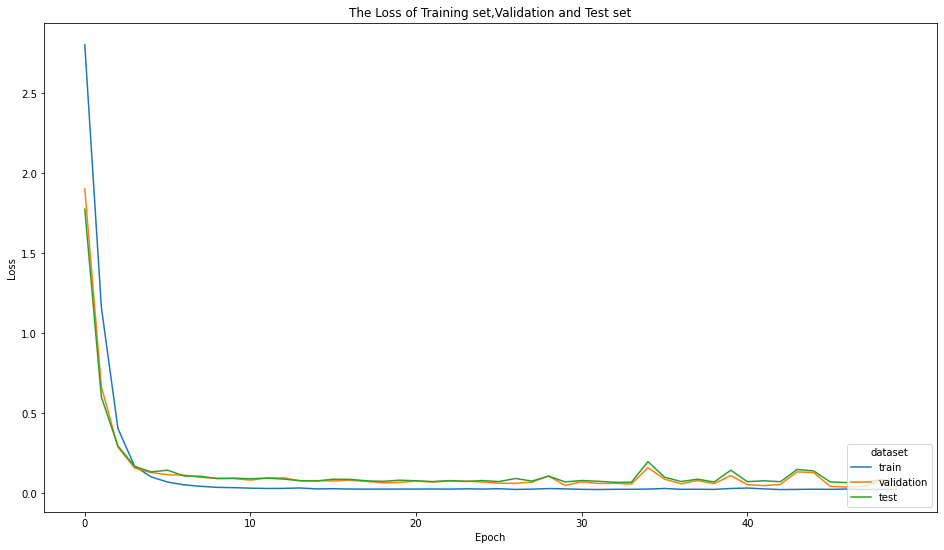

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df = pd.read_csv(r"record.csv",index_col=0)
train_record = df.loc['train_record',:]
val_record = df.loc['val_record',:]
test_record = df.loc['test_record',:]
train_acc = df.loc['train_acc',:]
val_acc = df.loc['val_acc',:]
test_acc = df.loc['test_acc',:]

plt.figure(figsize=(16,9))
sns.lineplot(data=train_record)
sns.lineplot(data=val_record)
sns.lineplot(data=test_record)
plt.title('The Loss of Training set,Validation and Test set')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.arange(0,50,10))
plt.legend(title='dataset', loc='lower right', labels=['train','validation','test'])

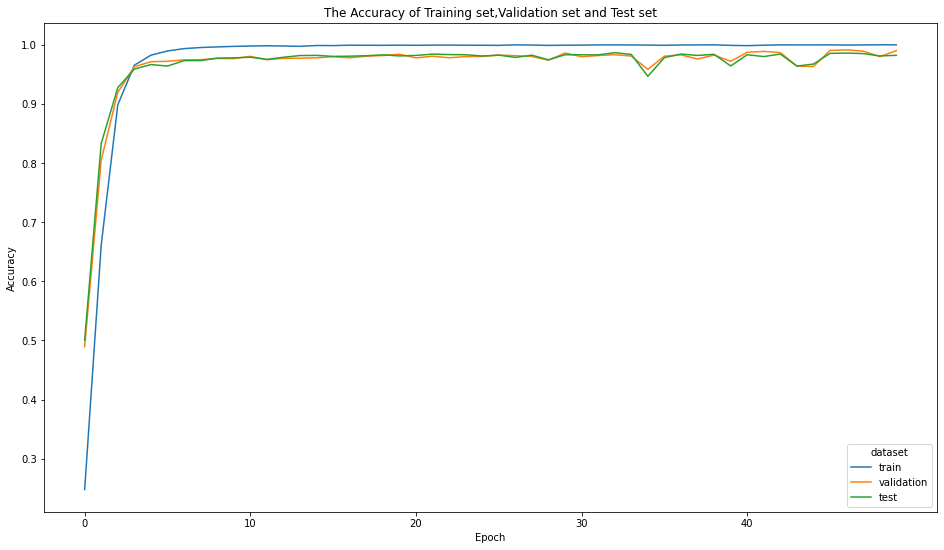

In [ ]:
plt.figure(figsize=(16,9))
sns.lineplot(data=train_acc)
sns.lineplot(data=val_acc)
sns.lineplot(data=test_acc)
plt.title('The Accuracy of Training set,Validation set and Test set')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(np.arange(0,50,10))
plt.legend(title='dataset', loc='lower right', labels=['train','validation','test'])